In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [01:56<00:00, 22.2MB/s]
100% 2.29G/2.29G [01:56<00:00, 21.1MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/chest-xray-pneumonia.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Convolution2D as Conv2D
from keras.layers import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout, Input
from keras.models import Sequential, Model
from keras.layers import Conv2D, GlobalMaxPool2D
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

#Import Data

In [ ]:
dataset_path = "/content/chest_xray/chest_xray"
classes = os.listdir(dataset_path)
print("Classes:", classes)

Classes: ['test', 'train', 'val', '.DS_Store']


In [ ]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import random

In [ ]:
def get_label(number):
  labels = {0: 'NORMAL', 1: "PNEUMONIA"}
  return labels[number]

In [ ]:
label = 1
print(get_label(label))

PNEUMONIA


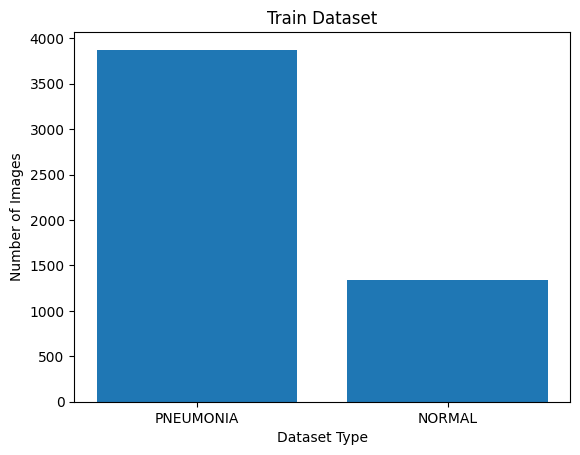

In [ ]:
path1 = '/content/chest_xray/train'
subfolders1 = os.listdir(path1)
subfolder_counts1 = [len(os.listdir(os.path.join(path1, subfolder))) for subfolder in subfolders1]

x_labels = subfolders1
x = range(len(x_labels))
y = subfolder_counts1
plt.bar(x, y)

plt.xticks(x, x_labels)
plt.xlabel('Dataset Type')
plt.ylabel('Number of Images')
plt.title('Train Dataset')

plt.show()

24


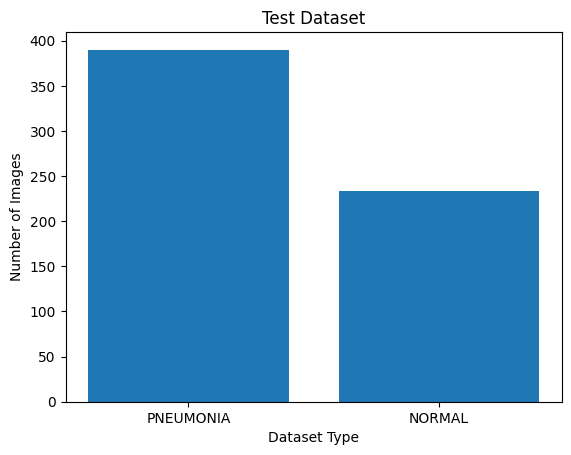

In [ ]:
path2 = '/content/chest_xray/test'
print(len(path2))
subfolders2 = os.listdir(path2)
subfolder_counts2 = [len(os.listdir(os.path.join(path2, subfolder))) for subfolder in subfolders2]

x_labels = subfolders2
x = range(len(x_labels))
y = subfolder_counts2
plt.bar(x, y)

plt.xticks(x, x_labels)
plt.xlabel('Dataset Type')
plt.ylabel('Number of Images')
plt.title('Test Dataset')
plt.show()

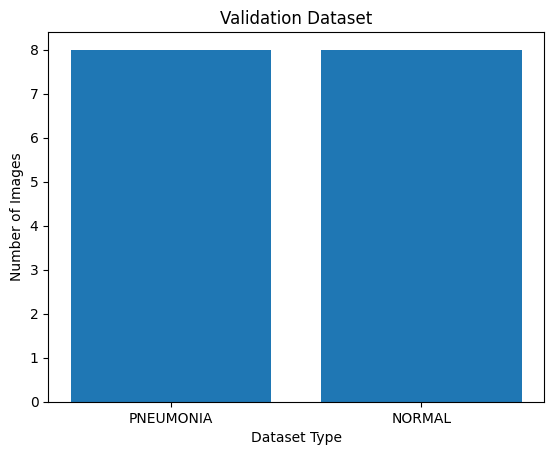

In [ ]:
path3 = '/content/chest_xray/val'

subfolders3 = os.listdir(path3)
subfolder_counts3 = [len(os.listdir(os.path.join(path3, subfolder))) for subfolder in subfolders3]

x_labels = subfolders3
x = range(len(x_labels))
y = subfolder_counts3
plt.bar(x, y)
plt.xticks(x, x_labels)
plt.xlabel('Dataset Type')
plt.ylabel('Number of Images')
plt.title('Validation Dataset')
plt.show()

In [ ]:
def load_images_from_directory(main_directory, foldername):
    images = []
    labels = []
    for label in os.listdir(os.path.join(main_directory, foldername)):
        folder_path = os.path.join(main_directory, foldername, label)
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            try:
                img = cv2.imread(image_path)
                img = cv2.resize(img, (150, 150))
                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")
    return images, labels

In [ ]:
main_directory = "/content/chest_xray"
train_images, train_labels = load_images_from_directory(main_directory, "train")
test_images, test_labels = load_images_from_directory(main_directory, "test")
val_images, val_labels = load_images_from_directory(main_directory, "val")

In [ ]:
train_count = (len(train_images))
test_count = (len(test_images))
val_count = (len(val_images))

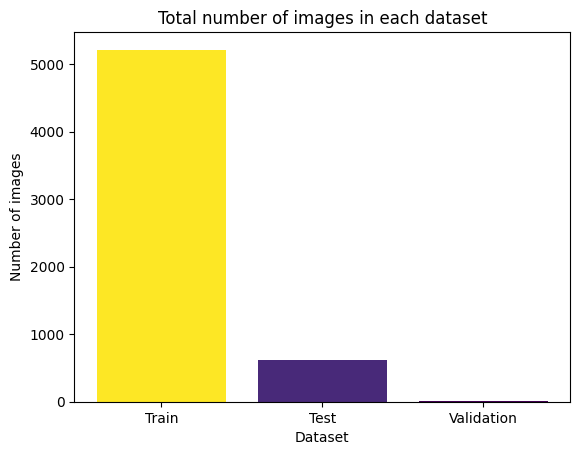

In [ ]:
import numpy as np
x_labels = ['Train', 'Test', 'Validation']
x = np.arange(len(x_labels))
y = [train_count, test_count, val_count]

cmap = plt.get_cmap('viridis')
normalize = plt.Normalize(vmin=min(y), vmax=max(y))

colors = [cmap(normalize(value)) for value in y]
plt.bar(x, y, color=colors)
plt.xticks(x, x_labels)
plt.xlabel('Dataset')
plt.ylabel('Number of images')
plt.title('Total number of images in each dataset')
plt.show()

#Data Visualization

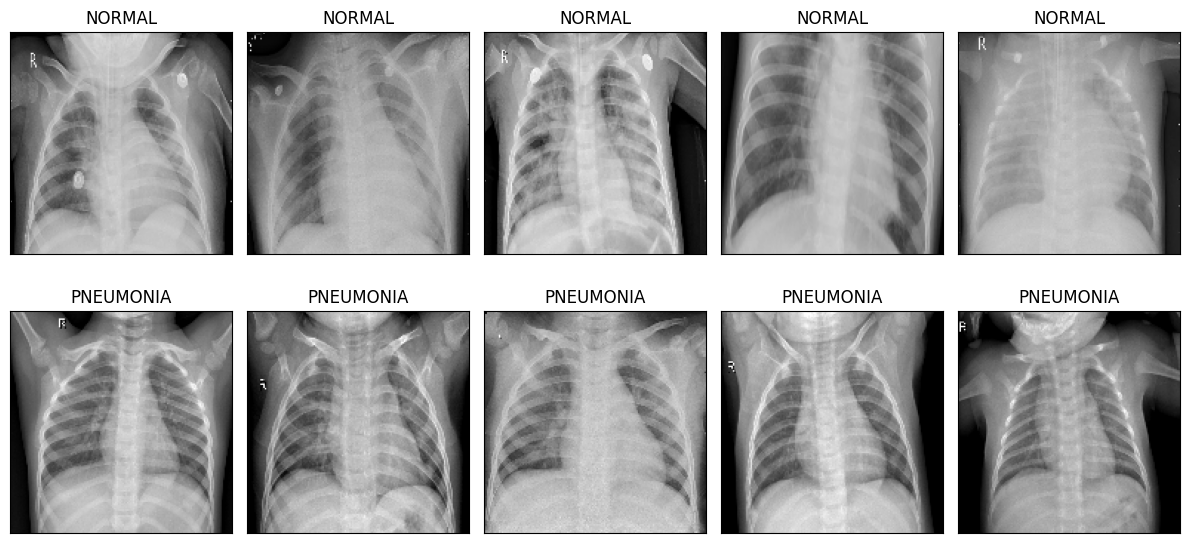

In [ ]:
def get_label(number):
    labels = {0: 'NORMAL', 1: 'PNEUMONIA'}
    return labels[number]

def load_images_from_directory(main_directory, foldername):
    images = []
    labels = []
    for label_number, label in enumerate(os.listdir(os.path.join(main_directory, foldername))):
        folder_path = os.path.join(main_directory, foldername, label)
        for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            try:
                img = cv2.imread(image_path)
                img = cv2.resize(img, (150, 150))
                images.append(img)
                labels.append(label_number)  # Use label_number instead of label
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")
    return images, labels

main_directory = "/content/chest_xray"
train_images, train_labels = load_images_from_directory(main_directory, "train")
test_images, test_labels = load_images_from_directory(main_directory, "test")
val_images, val_labels = load_images_from_directory(main_directory, "val")

# Combine all images and labels for easy filtering
all_images = train_images + test_images + val_images
all_labels = train_labels + test_labels + val_labels

# Create a dictionary to store sample images for each label
sample_images = {0: [], 1: []}

# Collect a few sample images for each label
for img, label in zip(all_images, all_labels):
    if len(sample_images[label]) < 5:  # Adjust the number of sample images to display
        sample_images[label].append(img)

# Visualize sample images
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(12, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axs.flat):
    label = get_label(i // 5)
    ax.imshow(sample_images[i // 5][i % 5])
    ax.set_title(label)

plt.tight_layout()
plt.show()


In [ ]:
# Print the total number of images in each set
print(f"Train set has {len(train_images)} images.")
print(f"Test set has {len(test_images)} images.")
print(f"Validation set has {len(val_images)} images.")

Train set has 5216 images.
Test set has 624 images.
Validation set has 16 images.


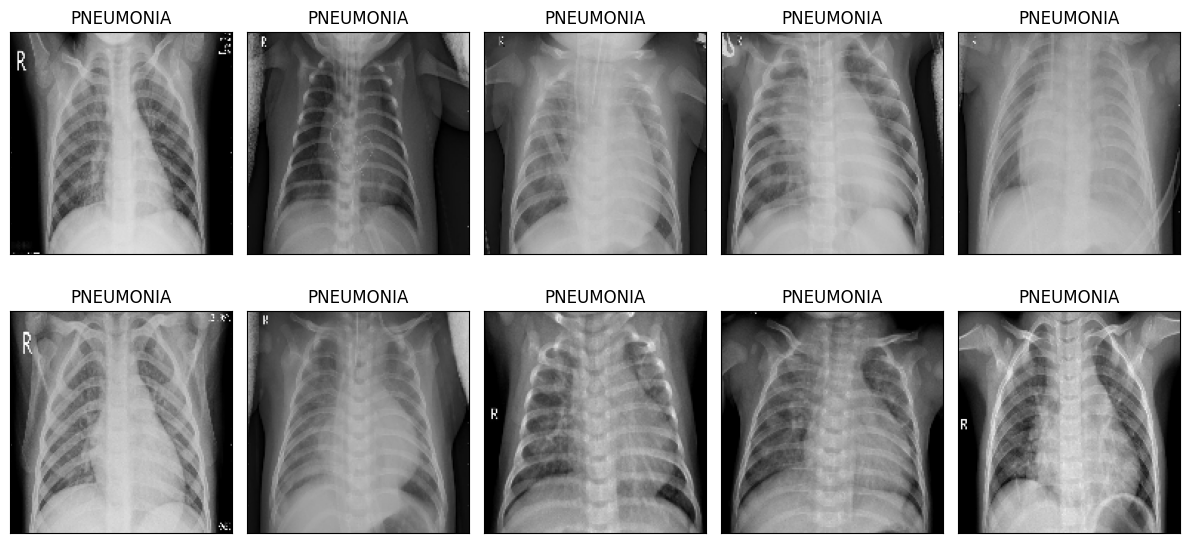

In [ ]:
num_images = min(10, len(test_images))

# Visualize the first num_images images from test_images
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(12, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axs.flat):
    if i < num_images:
        ax.imshow(test_images[i])
        ax.set_title(test_labels[i])
    else:
        ax.axis('off') # Hide the extra subplots

plt.tight_layout()
plt.show()

#Data Augmentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
main_directory = "/content/chest_xray"
train_generator = train_datagen.flow_from_directory(
    os.path.join(main_directory, 'train'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    os.path.join(main_directory, 'test'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

val_generator = val_datagen.flow_from_directory(
    os.path.join(main_directory, 'val'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


#create model

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation= 'relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation= 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation= 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation= 'relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)        0

In [ ]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [ ]:
steps_per_epoch = len(train_generator)

In [ ]:
# Print the number of training and validation steps
print("Number of training steps:", len(train_generator))
print("Number of validation steps:", len(val_generator))

validation_steps = len(val_generator) // val_generator.batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=val_generator,
    validation_steps=validation_steps
)


Number of training steps: 163
Number of validation steps: 1
Epoch 1/20
163/163 [==============================] - 92s 563ms/step - loss: 0.2934 - accuracy: 0.8725 - val_loss: 0.6046 - val_accuracy: 0.7500
Epoch 2/20
163/163 [==============================] - 81s 495ms/step - loss: 0.2529 - accuracy: 0.8953 - val_loss: 0.9508 - val_accuracy: 0.6875
Epoch 3/20
163/163 [==============================] - 76s 466ms/step - loss: 0.2135 - accuracy: 0.9199 - val_loss: 0.7107 - val_accuracy: 0.6875
Epoch 4/20
 42/163 [======>.......................] - ETA: 1:01 - loss: 0.2070 - accuracy: 0.9249

KeyboardInterrupt: ignored

In [ ]:
!pip install -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.2 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from kerastuner.tuners import Hyperband
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint  # Import EarlyStopping

<ipython-input-47-1faca7077023>:5: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import Hyperband


In [ ]:
# Define the model building function
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(hp.Int('units_dense1', min_value=64, max_value=256, step=32, default=128), activation='relu'))
    model.add(Dropout(hp.Float('dropout_rate1', min_value=0.3, max_value=0.7, step=0.1, default=0.5)))

    model.add(Dense(hp.Int('units_dense2', min_value=32, max_value=128, step=32, default=64), activation='relu'))
    model.add(Dropout(hp.Float('dropout_rate2', min_value=0.3, max_value=0.7, step=0.1, default=0.5)))

    model.add(Dense(1, activation='sigmoid'))

    # Choose optimizer based on hyperparameter
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3))
    elif optimizer_choice == 'rmsprop':
        optimizer = RMSprop(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3))
    else:
        optimizer = SGD(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3))

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

In [ ]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='/content/drive/MyDrive/Pneumonia/best_model.h5', monitor='val_accuracy', save_best_only=True)


In [ ]:
# Instantiate the tuner
tuner = Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='tuner_dir',
    project_name='/content/drive/MyDrive/Pneumonia/my_hyperparameter_tuning'
)


In [ ]:

# Search for the best hyperparameter configuration
tuner.search(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    callbacks=[early_stopping, model_checkpoint]
)

Trial 27 Complete [00h 07m 45s]
val_accuracy: 0.625

Best val_accuracy So Far: 0.875
Total elapsed time: 02h 34m 13s

Search: Running Trial #28

Value             |Best Value So Far |Hyperparameter
64                |64                |units_dense1
0.3               |0.4               |dropout_rate1
128               |96                |units_dense2
0.4               |0.6               |dropout_rate2
rmsprop           |rmsprop           |optimizer
0.001636          |0.0012997         |learning_rate
20                |3                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
0                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/20
163/163 [==============================] - 76s 453ms/step - loss: 0.5862 - accuracy: 0.7435 - val_loss: 0.7998 - val_accuracy: 0.5000
Epoch 2/20
163/163 [==============================] - 75s 458ms/step - loss: 0.3948 - accuracy: 0.8298 - val_loss: 2.6781 - val_accuracy: 0

In [ ]:
# Get the best hyperparameters
best_hps = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters
print(f"Best Hyperparameters: {best_hps}")

# Build the model with the best hyperparameters
best_model = tuner.oracle.get_best_trials(num_trials=1)[0].get_best_trial().model

In [ ]:
# Get the summary of the tuning process
tuner_results_summary = tuner.oracle.get_best_trials(num_trials=len(tuner.oracle.trials))

# Plot the hyperparameter tuning process
plt.figure(figsize=(10, 6))
plt.plot(tuner_results_summary['trial_id'], tuner_results_summary['value'], marker='o', linestyle='-', color='b')
plt.title('Hyperparameter Tuning Process')
plt.xlabel('Trial ID')
plt.ylabel('Objective Value (Validation Accuracy)')
plt.show()

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc *100)

20/20 [==============================] - 7s 328ms/step - loss: 0.2877 - accuracy: 0.9054
Test accuracy: 90.54487347602844


In [ ]:
model.save("/content/drive/MyDrive/BrainTumor/CNN_Model.h5py")

In [ ]:
def predict_image(filename):
  img = load_img(filename, target_size=(150, 150))
  image = keras.preprocessing.image.img_to_array(img)
  image = image/255.0
  image = image.reshape(1, 150, 150, 3)
  model = tf.keras.models.load_model('/content/drive/MyDrive/BrainTumor/CNN_Model.h5py')
  prediction = model.predict(image)
  print(prediction)
  plt.imshow(img)
  if(prediction[0] > 0.5):
    stat = prediction[0] * 100
    print('This image is %.2f percent %s'%(stat, 'PNEUMONIA'))
  else:
    stat = (1.0 - prediction[0]) *100
    print('This image is %.2f percent %s'%(stat, 'NORMAL'))

In [ ]:
image0= '/content/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg'
image1="/content/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg"

Predicted image0
1/1 [==============================] - 0s 389ms/step
[[0.8425163]]
This image is 84.25 percent PNEUMONIA


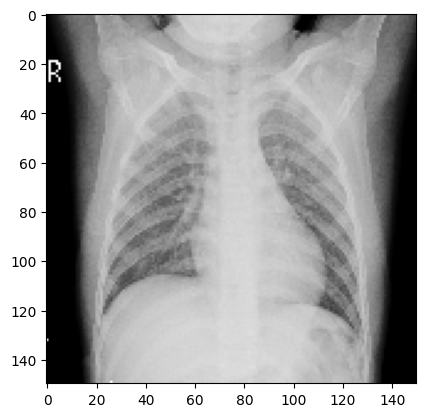

In [ ]:
print("Predicted image0")
predict_image(image0)

Predicted image1
1/1 [==============================] - 0s 142ms/step
[[0.8618582]]
This image is 86.19 percent PNEUMONIA


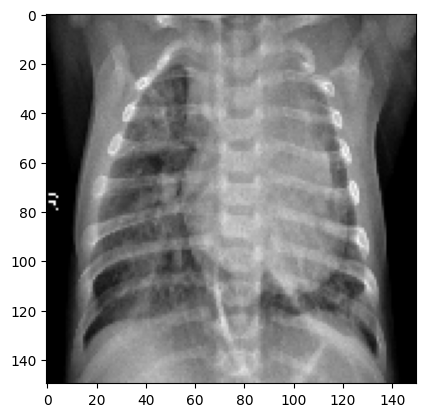

In [ ]:
print("Predicted image1")
predict_image(image1)

Transfer Learning

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

In [ ]:
# Load the pre-trained VGG16 model
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150,150,3)
                  )

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
model2=Sequential()
model2.add(conv_base)
model2.add(Flatten())
model2.add(Dense(256,activation='relu'))
model2.add(Dense(1,activation='sigmoid'))

In [ ]:
conv_base.trainable=False

In [ ]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               2097408   
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
              )

In [ ]:
history2 = model2.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=5,
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size
)

Epoch 1/5
163/163 [==============================] - 100s 561ms/step - loss: 0.2445 - accuracy: 0.9036
Epoch 2/5
163/163 [==============================] - 90s 552ms/step - loss: 0.1470 - accuracy: 0.9434
Epoch 3/5
163/163 [==============================] - 89s 547ms/step - loss: 0.1456 - accuracy: 0.9482
Epoch 4/5
163/163 [==============================] - 90s 549ms/step - loss: 0.1328 - accuracy: 0.9494
Epoch 5/5
163/163 [==============================] - 89s 548ms/step - loss: 0.1201 - accuracy: 0.9549


In [ ]:
test_loss, test_acc1 = model2.evaluate(test_generator)
print('Test accuracy:', test_acc1* 100)

20/20 [==============================] - 7s 345ms/step - loss: 0.2856 - accuracy: 0.9119
Test accuracy: 91.18589758872986


In [ ]:
model.save("/content/drive/MyDrive/BrainTumor/T_model1.h5py")

In [ ]:
def predict_image1(filename):
  img = load_img(filename, target_size=(150, 150))
  image = keras.preprocessing.image.img_to_array(img)
  image = image/255.0
  image = image.reshape(1, 150, 150, 3)
  model = tf.keras.models.load_model('/content/drive/MyDrive/BrainTumor/T_model1.h5py')
  prediction = model.predict(image)
  print(prediction)
  plt.imshow(img)
  if(prediction[0] > 0.5):
    stat = prediction[0] * 100
    print('This image is %.2f percent %s'%(stat, 'PNEUMONIA'))
  else:
    stat = (1.0 - prediction[0]) *100
    print('This image is %.2f percent %s'%(stat, 'NORMAL'))

In [ ]:
image0= '/content/chest_xray/val/NORMAL/NORMAL2-IM-1427-0001.jpeg'
image1="/content/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg"

Predicted image1
1/1 [==============================] - 0s 136ms/step
[[0.8618582]]
This image is 86.19 percent PNEUMONIA


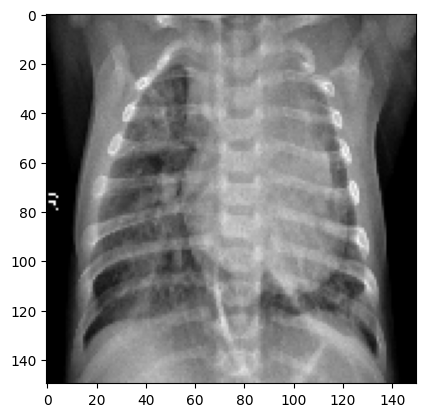

In [ ]:
print("Predicted image1")
predict_image1(image1)

Predicted image0
1/1 [==============================] - 0s 92ms/step
[[0.8425163]]
This image is 84.25 percent PNEUMONIA


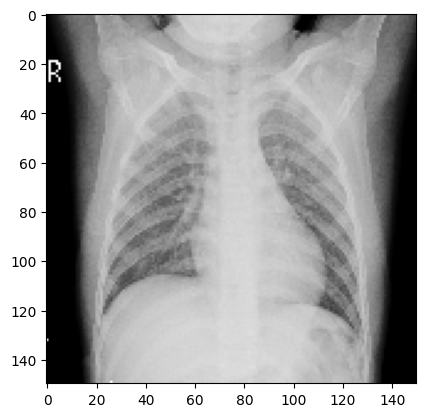

In [ ]:
print("Predicted image0")
predict_image1(image0)

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [ ]:
resnet = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(150,150,3))

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
model3=Sequential()
model3.add(resnet)
model3.add(Flatten())
model3.add(Dense(256,activation='relu'))
model3.add(Dense(1,activation='sigmoid'))

In [ ]:
resnet.trainable=False

In [ ]:
# Compile the model
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history3 = model3.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=5,
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size)

Epoch 1/5
163/163 [==============================] - 90s 523ms/step - loss: 0.5661 - accuracy: 0.7490
Epoch 2/5
163/163 [==============================] - 87s 531ms/step - loss: 0.4099 - accuracy: 0.8008
Epoch 3/5
163/163 [==============================] - 87s 533ms/step - loss: 0.3429 - accuracy: 0.8472
Epoch 4/5
163/163 [==============================] - 87s 534ms/step - loss: 0.3334 - accuracy: 0.8493
Epoch 5/5
163/163 [==============================] - 88s 539ms/step - loss: 0.2995 - accuracy: 0.8662


In [ ]:
test_loss, test_acc2 = model3.evaluate(test_generator)
print('Test accuracy:', test_acc2 *100)

20/20 [==============================] - 8s 314ms/step - loss: 0.3275 - accuracy: 0.8526
Test accuracy: 85.25640964508057


In [ ]:
model.save("/content/drive/MyDrive/BrainTumor/T_model2.h5py")

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
inception = InceptionV3(include_top=False, weights='imagenet', input_shape=(150, 150, 3))

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
model4=Sequential()
model4.add(inception)
model4.add(Flatten())
model4.add(Dense(256,activation='relu'))
model4.add(Dense(1,activation='sigmoid'))

In [ ]:
resnet.trainable=False

In [ ]:
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history4 = model4.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=5,
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size
)

Epoch 1/5
163/163 [==============================] - 133s 539ms/step - loss: 0.3004 - accuracy: 0.9128
Epoch 2/5
163/163 [==============================] - 88s 537ms/step - loss: 0.1508 - accuracy: 0.9417
Epoch 3/5
163/163 [==============================] - 89s 545ms/step - loss: 0.2807 - accuracy: 0.9517
Epoch 4/5
163/163 [==============================] - 89s 544ms/step - loss: 0.2430 - accuracy: 0.9245
Epoch 5/5
163/163 [==============================] - 91s 558ms/step - loss: 0.1511 - accuracy: 0.9479


In [ ]:
test_loss, test_acc3 = model4.evaluate(test_generator)
print('Test accuracy:', test_acc3 *100)

20/20 [==============================] - 9s 395ms/step - loss: 0.4579 - accuracy: 0.8093
Test accuracy: 80.92948794364929


In [ ]:
model.save("/content/drive/MyDrive/BrainTumor/T_model3.h5py")

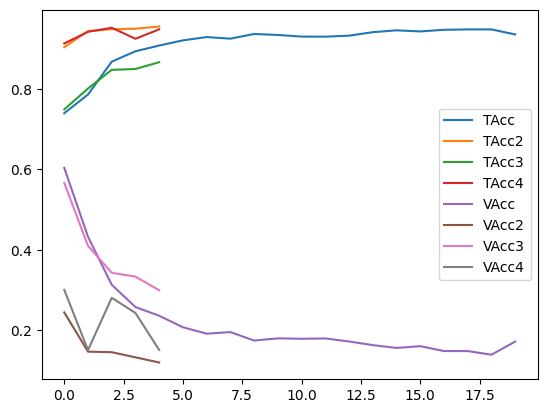

In [ ]:
plt.plot(history.history['accuracy'],label='TAcc')
plt.plot(history2.history['accuracy'],label='TAcc2')
plt.plot(history3.history['accuracy'],label='TAcc3')
plt.plot(history4.history['accuracy'],label='TAcc4')

plt.plot(history.history['loss'],label='VAcc')
plt.plot(history2.history['loss'],label='VAcc2')
plt.plot(history3.history['loss'],label='VAcc3')
plt.plot(history4.history['loss'],label='VAcc4')
plt.legend()
plt.show()

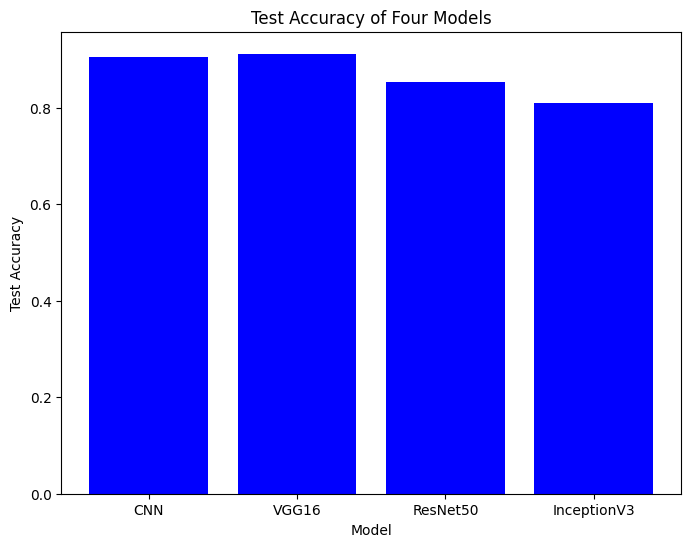

In [ ]:

test_accs = [test_acc, test_acc1, test_acc2, test_acc3]

model_names = ['CNN', 'VGG16', 'ResNet50', 'InceptionV3']

plt.figure(figsize=(8,6))
plt.bar(model_names, test_accs, color='b')
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy of Four Models')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
from keras.preprocessing.image import ImageDataGenerator


test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        '/content/chest_xray/test',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary',
        shuffle=False)


Found 624 images belonging to 2 classes.


In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


20/20 [==============================] - 7s 306ms/step
Confusion Matrix
[[182  52]
 [  7 383]]
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.78      0.86       234
           1       0.88      0.98      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.88      0.89       624
weighted avg       0.91      0.91      0.90       624

Precision: 0.91
Recall: 0.91
F1-Score: 0.90


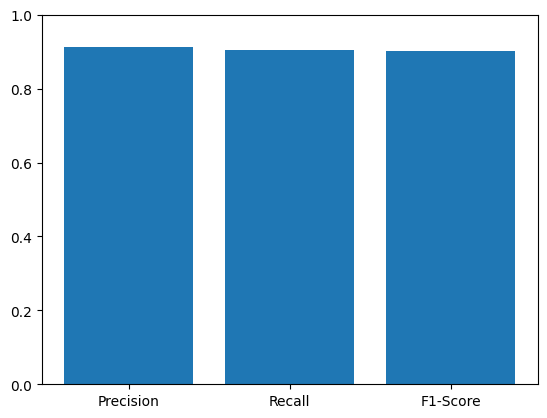

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
y_pred = model.predict(test_generator)
y_true = test_generator.classes
cm = confusion_matrix(y_true, np.round(y_pred))
print('Confusion Matrix')
print(cm)

print('Classification Report')
print(classification_report(y_true, np.round(y_pred)))

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, np.round(y_pred), average='weighted')

print('Precision: {:.2f}'.format(precision))
print('Recall: {:.2f}'.format(recall))
print('F1-Score: {:.2f}'.format(f1_score))

plt.bar(['Precision', 'Recall', 'F1-Score'], [precision, recall, f1_score])
plt.ylim(0, 1)
plt.show()


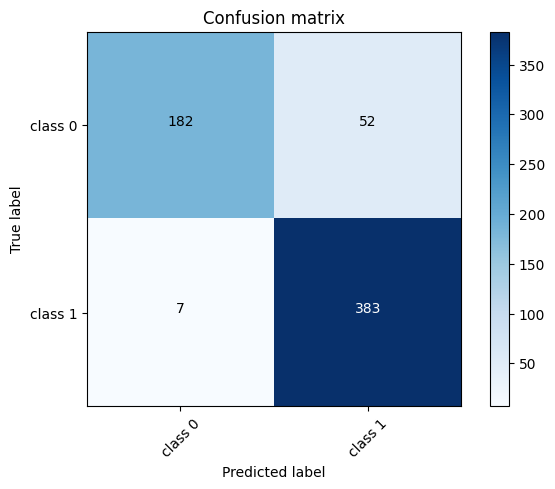

In [ ]:
# calculate the confusion matrix
cm = confusion_matrix(y_true, np.round(y_pred))
# plot the confusion matrix
plot_confusion_matrix(cm, classes=['class 0', 'class 1'])
plt.show()

20/20 [==============================] - 7s 310ms/step
Confusion Matrix
[[186  48]
 [  7 383]]
Classification Report
              precision    recall  f1-score   support

           0       0.96      0.79      0.87       234
           1       0.89      0.98      0.93       390

    accuracy                           0.91       624
   macro avg       0.93      0.89      0.90       624
weighted avg       0.92      0.91      0.91       624

Precision: 0.92
Recall: 0.91
F1-Score: 0.91


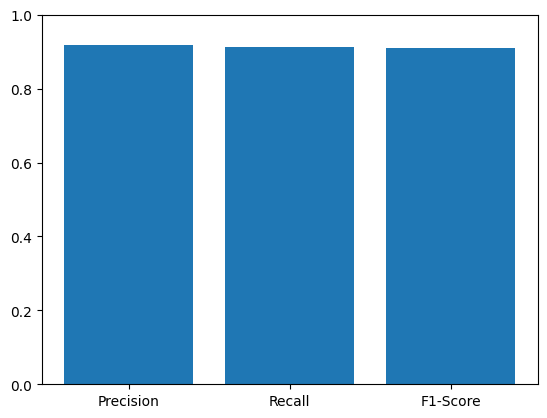

In [ ]:
y_pred2 = model2.predict(test_generator)
y_true2 = test_generator.classes
cm2 = confusion_matrix(y_true2, np.round(y_pred2))
print('Confusion Matrix')
print(cm2)

print('Classification Report')
print(classification_report(y_true2, np.round(y_pred2)))

precision2, recall2, f1_score2, _ = precision_recall_fscore_support(y_true2, np.round(y_pred2), average='weighted')

print('Precision: {:.2f}'.format(precision2))
print('Recall: {:.2f}'.format(recall2))
print('F1-Score: {:.2f}'.format(f1_score2))

plt.bar(['Precision', 'Recall', 'F1-Score'], [precision2, recall2, f1_score2])
plt.ylim(0, 1)
plt.show()

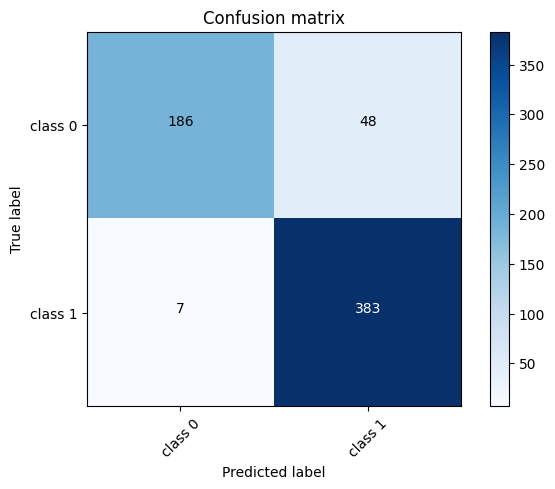

In [ ]:
# calculate the confusion matrix
cm2 = confusion_matrix(y_true2, np.round(y_pred2))
# plot the confusion matrix
plot_confusion_matrix(cm2, classes=['class 0', 'class 1'])
plt.show()

20/20 [==============================] - 8s 330ms/step
Confusion Matrix
[[169  65]
 [ 27 363]]
Classification Report
              precision    recall  f1-score   support

           0       0.86      0.72      0.79       234
           1       0.85      0.93      0.89       390

    accuracy                           0.85       624
   macro avg       0.86      0.83      0.84       624
weighted avg       0.85      0.85      0.85       624

Precision: 0.85
Recall: 0.85
F1-Score: 0.85


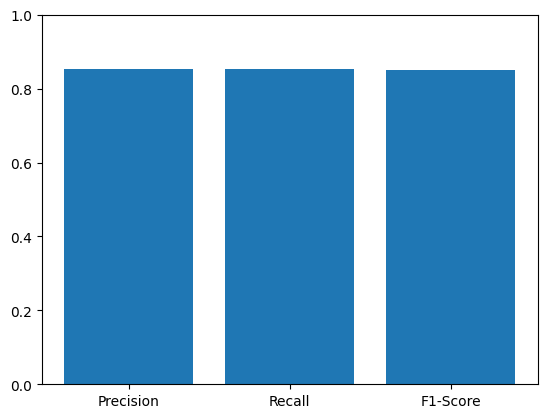

In [ ]:
y_pred3 = model3.predict(test_generator)
y_true3 = test_generator.classes
cm3 = confusion_matrix(y_true3, np.round(y_pred3))
print('Confusion Matrix')
print(cm3)

print('Classification Report')
print(classification_report(y_true3, np.round(y_pred3)))

precision3, recall3, f1_score3, _ = precision_recall_fscore_support(y_true3, np.round(y_pred3), average='weighted')

print('Precision: {:.2f}'.format(precision3))
print('Recall: {:.2f}'.format(recall3))
print('F1-Score: {:.2f}'.format(f1_score3))

plt.bar(['Precision', 'Recall', 'F1-Score'], [precision3, recall3, f1_score3])
plt.ylim(0, 1)
plt.show()

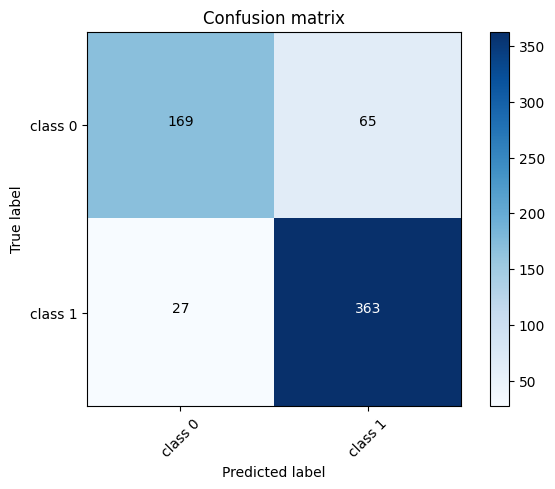

In [ ]:
# calculate the confusion matrix
cm3 = confusion_matrix(y_true3, np.round(y_pred3))
# plot the confusion matrix
plot_confusion_matrix(cm3, classes=['class 0', 'class 1'])
plt.show()

20/20 [==============================] - 7s 248ms/step
Confusion Matrix
[[225   9]
 [110 280]]
Classification Report
              precision    recall  f1-score   support

           0       0.67      0.96      0.79       234
           1       0.97      0.72      0.82       390

    accuracy                           0.81       624
   macro avg       0.82      0.84      0.81       624
weighted avg       0.86      0.81      0.81       624

Precision: 0.92
Recall: 0.91
F1-Score: 0.91


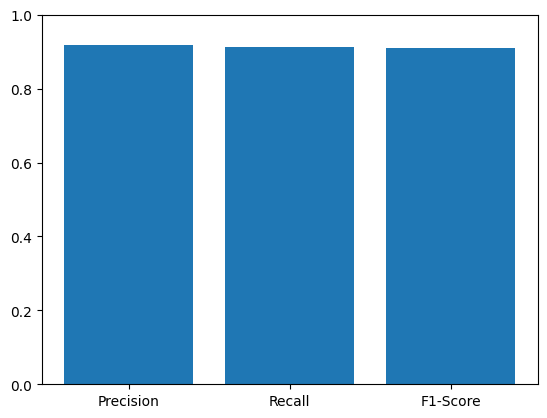

In [ ]:
y_pred4 = model4.predict(test_generator)
y_true4 = test_generator.classes
cm4 = confusion_matrix(y_true4, np.round(y_pred4))
print('Confusion Matrix')
print(cm4)

print('Classification Report')
print(classification_report(y_true4, np.round(y_pred4)))

precision4, recall4, f1_score4, _ = precision_recall_fscore_support(y_true2, np.round(y_pred2), average='weighted')

print('Precision: {:.2f}'.format(precision4))
print('Recall: {:.2f}'.format(recall4))
print('F1-Score: {:.2f}'.format(f1_score4))

plt.bar(['Precision', 'Recall', 'F1-Score'], [precision4, recall4, f1_score4])
plt.ylim(0, 1)
plt.show()

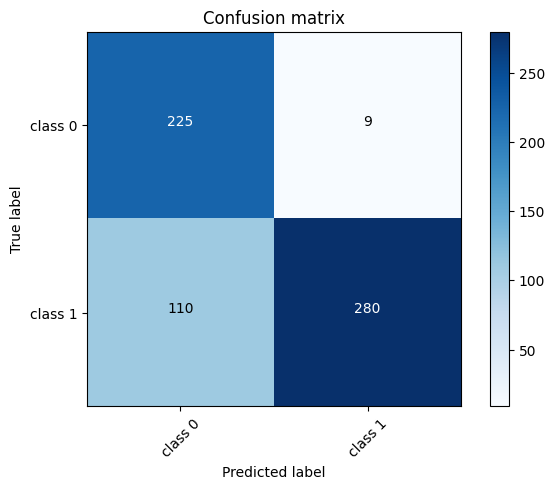

In [ ]:
# calculate the confusion matrix
cm4 = confusion_matrix(y_true4, np.round(y_pred4))
# plot the confusion matrix
plot_confusion_matrix(cm4, classes=['class 0', 'class 1'])
plt.show()